# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

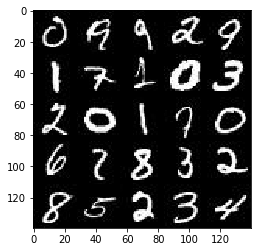

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

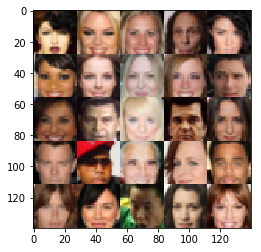

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example

    alpha = 0.2
    kernel_size = 4
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=0.75)
        #print(x1.get_shape())
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.75)
        #print(x2.get_shape())
        # 7x7x128
                
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.75)
        #print(x3.get_shape())
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        #print(flat.get_shape())
        logits = tf.layers.dense(flat, 1)
        #print(logits.get_shape())
        out = tf.sigmoid(logits)
        #print(out.get_shape())
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    alpha = 0.2
    reuse = not is_train
    kernel_size = 4
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        #print(x1.get_shape())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape())
        # 28x28x5 now
                
        out = tf.tanh(logits)
        #print(out.get_shape())
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    n_images = 16
    print_every = 100
    show_every = 200
    
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
                               
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # tip from reviewer, rescales images from -0.5, 0.5 to -1, 1
                batch_images*=2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} (step: {})...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 (step: 100)... Discriminator Loss: 1.1702... Generator Loss: 2.5510
Epoch 1/2 (step: 200)... Discriminator Loss: 1.0884... Generator Loss: 0.7834


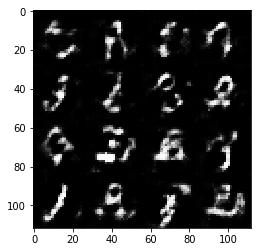

Epoch 1/2 (step: 300)... Discriminator Loss: 1.6790... Generator Loss: 0.3012
Epoch 1/2 (step: 400)... Discriminator Loss: 1.2977... Generator Loss: 1.4386


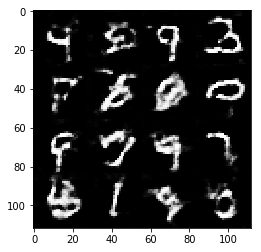

Epoch 1/2 (step: 500)... Discriminator Loss: 1.2547... Generator Loss: 0.4960
Epoch 1/2 (step: 600)... Discriminator Loss: 1.0734... Generator Loss: 0.8427


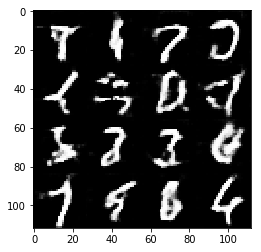

Epoch 1/2 (step: 700)... Discriminator Loss: 1.0929... Generator Loss: 0.8657
Epoch 1/2 (step: 800)... Discriminator Loss: 1.2206... Generator Loss: 0.4940


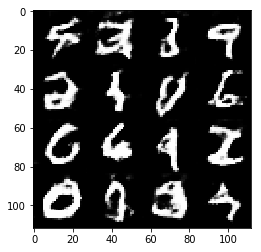

Epoch 1/2 (step: 900)... Discriminator Loss: 0.8174... Generator Loss: 1.4320
Epoch 2/2 (step: 1000)... Discriminator Loss: 1.0389... Generator Loss: 2.8884


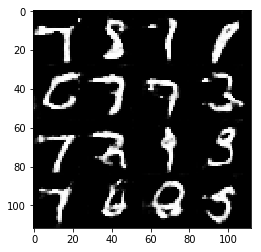

Epoch 2/2 (step: 1100)... Discriminator Loss: 0.6813... Generator Loss: 1.0579
Epoch 2/2 (step: 1200)... Discriminator Loss: 0.4993... Generator Loss: 1.4223


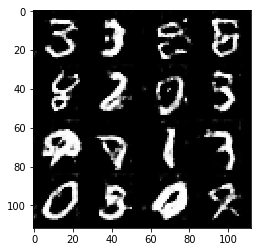

Epoch 2/2 (step: 1300)... Discriminator Loss: 0.4361... Generator Loss: 1.9623
Epoch 2/2 (step: 1400)... Discriminator Loss: 0.4514... Generator Loss: 2.0628


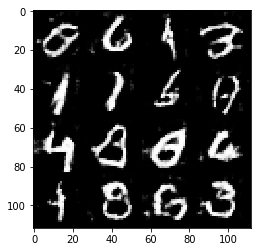

Epoch 2/2 (step: 1500)... Discriminator Loss: 0.6645... Generator Loss: 1.0798
Epoch 2/2 (step: 1600)... Discriminator Loss: 1.2316... Generator Loss: 0.4712


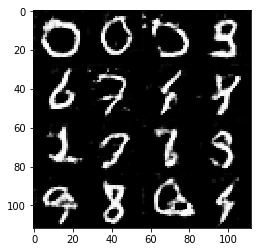

Epoch 2/2 (step: 1700)... Discriminator Loss: 0.2414... Generator Loss: 1.9324
Epoch 2/2 (step: 1800)... Discriminator Loss: 1.8831... Generator Loss: 0.2859


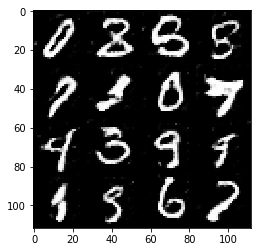

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10 (step: 100)... Discriminator Loss: 0.6634... Generator Loss: 2.0176
Epoch 1/10 (step: 200)... Discriminator Loss: 0.4828... Generator Loss: 4.2259


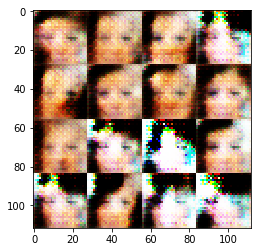

Epoch 1/10 (step: 300)... Discriminator Loss: 0.1854... Generator Loss: 4.3741
Epoch 1/10 (step: 400)... Discriminator Loss: 0.8618... Generator Loss: 3.1327


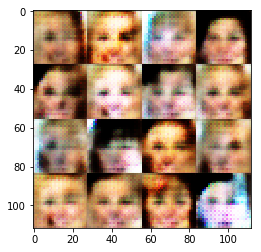

Epoch 1/10 (step: 500)... Discriminator Loss: 0.3919... Generator Loss: 2.0432
Epoch 1/10 (step: 600)... Discriminator Loss: 0.8206... Generator Loss: 0.8990


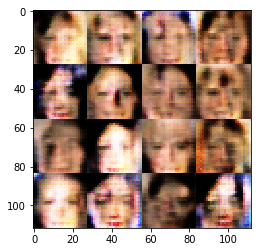

Epoch 1/10 (step: 700)... Discriminator Loss: 1.0382... Generator Loss: 0.9948
Epoch 1/10 (step: 800)... Discriminator Loss: 0.0671... Generator Loss: 4.7806


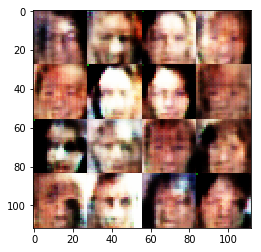

Epoch 1/10 (step: 900)... Discriminator Loss: 0.5383... Generator Loss: 1.4086
Epoch 1/10 (step: 1000)... Discriminator Loss: 0.8311... Generator Loss: 3.2228


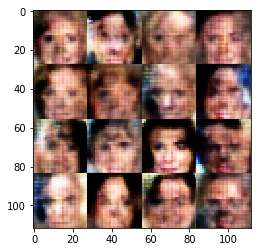

Epoch 1/10 (step: 1100)... Discriminator Loss: 1.0987... Generator Loss: 2.4671
Epoch 1/10 (step: 1200)... Discriminator Loss: 0.7231... Generator Loss: 0.8916


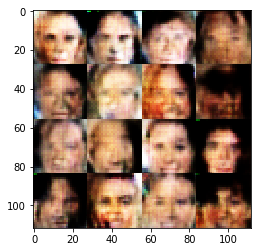

Epoch 1/10 (step: 1300)... Discriminator Loss: 0.4067... Generator Loss: 1.6979
Epoch 1/10 (step: 1400)... Discriminator Loss: 0.8360... Generator Loss: 0.9954


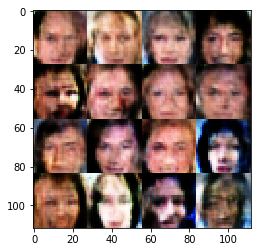

Epoch 1/10 (step: 1500)... Discriminator Loss: 0.6180... Generator Loss: 1.4164
Epoch 1/10 (step: 1600)... Discriminator Loss: 0.5300... Generator Loss: 1.2526


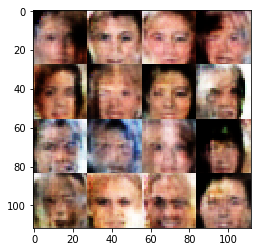

Epoch 1/10 (step: 1700)... Discriminator Loss: 0.3225... Generator Loss: 2.0933
Epoch 1/10 (step: 1800)... Discriminator Loss: 0.8922... Generator Loss: 0.9270


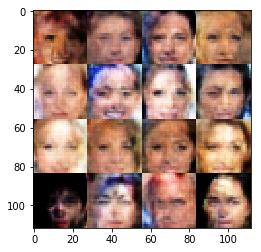

Epoch 1/10 (step: 1900)... Discriminator Loss: 1.8600... Generator Loss: 3.2559
Epoch 1/10 (step: 2000)... Discriminator Loss: 3.0318... Generator Loss: 0.1013


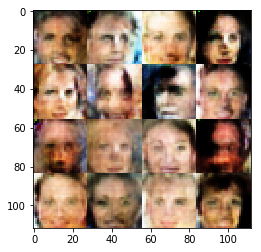

Epoch 1/10 (step: 2100)... Discriminator Loss: 0.3249... Generator Loss: 1.8862
Epoch 1/10 (step: 2200)... Discriminator Loss: 0.2820... Generator Loss: 4.9945


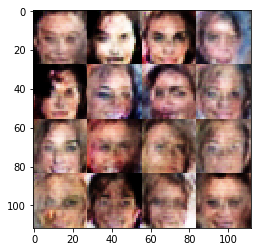

Epoch 1/10 (step: 2300)... Discriminator Loss: 0.4425... Generator Loss: 1.9931
Epoch 1/10 (step: 2400)... Discriminator Loss: 0.3963... Generator Loss: 1.9299


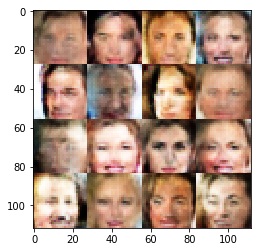

Epoch 1/10 (step: 2500)... Discriminator Loss: 0.2994... Generator Loss: 1.8272
Epoch 1/10 (step: 2600)... Discriminator Loss: 0.2957... Generator Loss: 2.2226


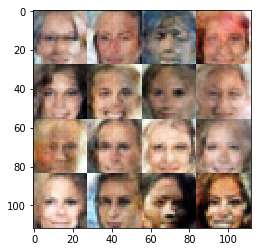

Epoch 1/10 (step: 2700)... Discriminator Loss: 0.9000... Generator Loss: 0.8708
Epoch 1/10 (step: 2800)... Discriminator Loss: 0.2647... Generator Loss: 3.6763


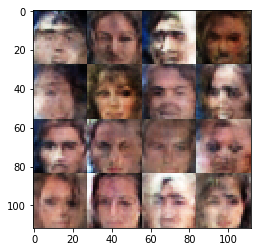

Epoch 1/10 (step: 2900)... Discriminator Loss: 1.2042... Generator Loss: 0.6759
Epoch 1/10 (step: 3000)... Discriminator Loss: 0.6788... Generator Loss: 1.2132


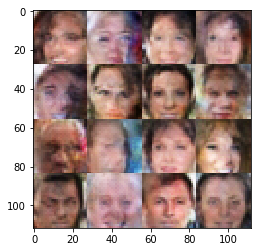

Epoch 1/10 (step: 3100)... Discriminator Loss: 1.1049... Generator Loss: 0.6806
Epoch 2/10 (step: 3200)... Discriminator Loss: 0.6345... Generator Loss: 1.6765


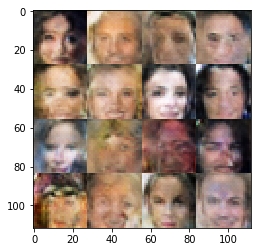

Epoch 2/10 (step: 3300)... Discriminator Loss: 0.4679... Generator Loss: 1.3660
Epoch 2/10 (step: 3400)... Discriminator Loss: 0.4746... Generator Loss: 2.5562


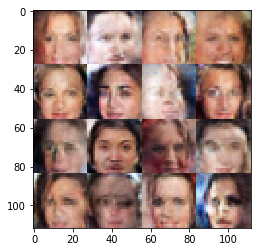

Epoch 2/10 (step: 3500)... Discriminator Loss: 0.5439... Generator Loss: 2.5640
Epoch 2/10 (step: 3600)... Discriminator Loss: 0.6462... Generator Loss: 2.0314


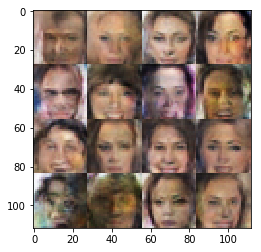

Epoch 2/10 (step: 3700)... Discriminator Loss: 0.2432... Generator Loss: 4.8992
Epoch 2/10 (step: 3800)... Discriminator Loss: 0.4201... Generator Loss: 1.8591


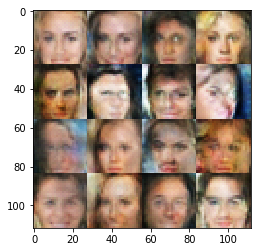

Epoch 2/10 (step: 3900)... Discriminator Loss: 0.9017... Generator Loss: 0.8561
Epoch 2/10 (step: 4000)... Discriminator Loss: 0.4171... Generator Loss: 2.1024


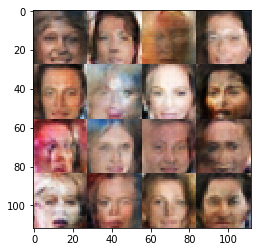

Epoch 2/10 (step: 4100)... Discriminator Loss: 0.6669... Generator Loss: 1.1387
Epoch 2/10 (step: 4200)... Discriminator Loss: 0.4470... Generator Loss: 1.7408


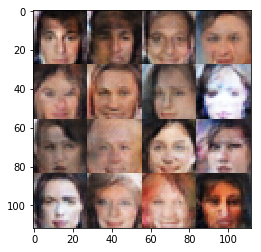

Epoch 2/10 (step: 4300)... Discriminator Loss: 0.4495... Generator Loss: 1.4922
Epoch 2/10 (step: 4400)... Discriminator Loss: 1.6708... Generator Loss: 0.4785


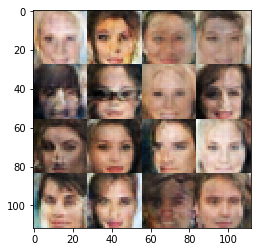

Epoch 2/10 (step: 4500)... Discriminator Loss: 0.6068... Generator Loss: 2.8678
Epoch 2/10 (step: 4600)... Discriminator Loss: 0.3671... Generator Loss: 2.0070


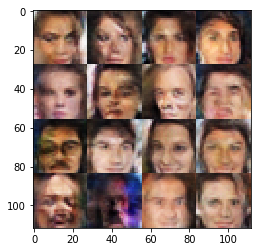

Epoch 2/10 (step: 4700)... Discriminator Loss: 0.5302... Generator Loss: 1.7694
Epoch 2/10 (step: 4800)... Discriminator Loss: 0.7779... Generator Loss: 1.0080


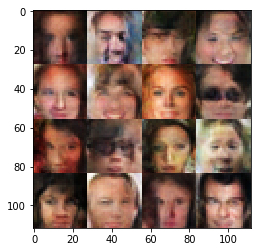

Epoch 2/10 (step: 4900)... Discriminator Loss: 0.9062... Generator Loss: 1.0949
Epoch 2/10 (step: 5000)... Discriminator Loss: 0.3044... Generator Loss: 2.6550


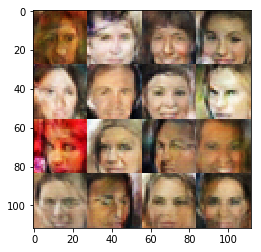

Epoch 2/10 (step: 5100)... Discriminator Loss: 1.3811... Generator Loss: 0.5044
Epoch 2/10 (step: 5200)... Discriminator Loss: 0.5455... Generator Loss: 2.3832


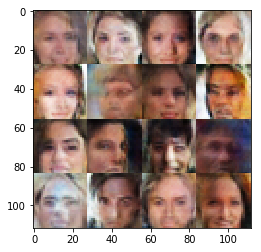

Epoch 2/10 (step: 5300)... Discriminator Loss: 0.6862... Generator Loss: 1.4942
Epoch 2/10 (step: 5400)... Discriminator Loss: 0.5137... Generator Loss: 1.3559


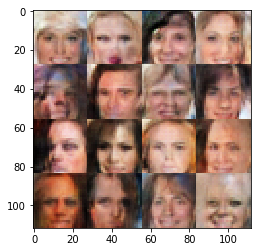

Epoch 2/10 (step: 5500)... Discriminator Loss: 0.5057... Generator Loss: 4.2820
Epoch 2/10 (step: 5600)... Discriminator Loss: 1.0953... Generator Loss: 3.0026


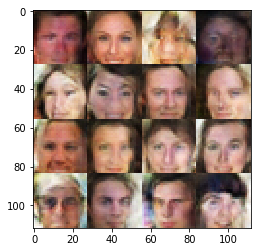

Epoch 2/10 (step: 5700)... Discriminator Loss: 0.6692... Generator Loss: 5.3145
Epoch 2/10 (step: 5800)... Discriminator Loss: 0.5985... Generator Loss: 1.9173


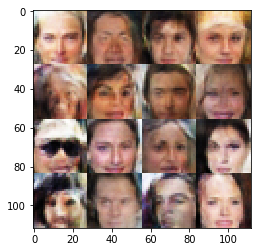

Epoch 2/10 (step: 5900)... Discriminator Loss: 0.5927... Generator Loss: 1.3803
Epoch 2/10 (step: 6000)... Discriminator Loss: 0.1583... Generator Loss: 3.0892


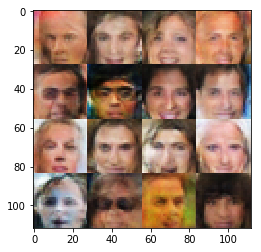

Epoch 2/10 (step: 6100)... Discriminator Loss: 0.5222... Generator Loss: 1.5072
Epoch 2/10 (step: 6200)... Discriminator Loss: 0.4235... Generator Loss: 1.7604


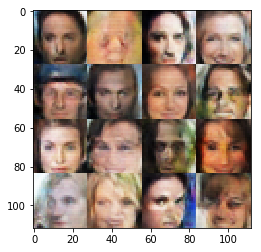

Epoch 2/10 (step: 6300)... Discriminator Loss: 0.3431... Generator Loss: 2.1604
Epoch 3/10 (step: 6400)... Discriminator Loss: 1.7075... Generator Loss: 0.4142


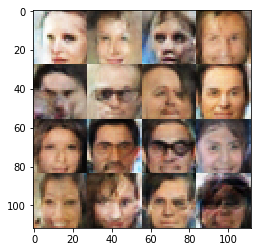

Epoch 3/10 (step: 6500)... Discriminator Loss: 0.1577... Generator Loss: 3.6230
Epoch 3/10 (step: 6600)... Discriminator Loss: 0.2952... Generator Loss: 2.6775


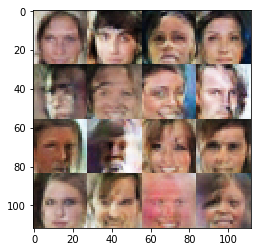

Epoch 3/10 (step: 6700)... Discriminator Loss: 0.7204... Generator Loss: 1.1077
Epoch 3/10 (step: 6800)... Discriminator Loss: 0.5522... Generator Loss: 2.9283


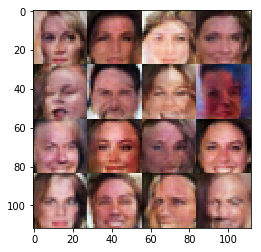

Epoch 3/10 (step: 6900)... Discriminator Loss: 0.6473... Generator Loss: 2.8264
Epoch 3/10 (step: 7000)... Discriminator Loss: 0.1496... Generator Loss: 3.2078


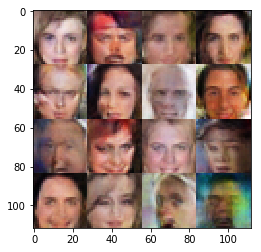

Epoch 3/10 (step: 7100)... Discriminator Loss: 0.1307... Generator Loss: 3.5879
Epoch 3/10 (step: 7200)... Discriminator Loss: 0.1607... Generator Loss: 4.5507


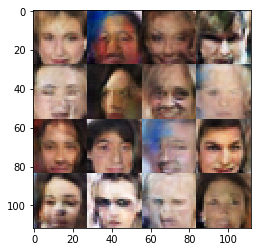

Epoch 3/10 (step: 7300)... Discriminator Loss: 0.2392... Generator Loss: 2.6032
Epoch 3/10 (step: 7400)... Discriminator Loss: 0.4065... Generator Loss: 1.6053


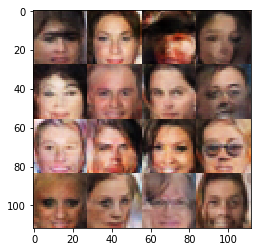

Epoch 3/10 (step: 7500)... Discriminator Loss: 0.1962... Generator Loss: 3.1353
Epoch 3/10 (step: 7600)... Discriminator Loss: 0.0981... Generator Loss: 5.4898


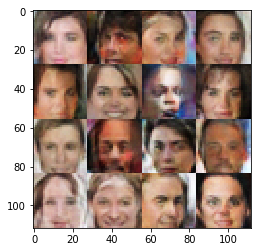

Epoch 3/10 (step: 7700)... Discriminator Loss: 0.4820... Generator Loss: 3.0592
Epoch 3/10 (step: 7800)... Discriminator Loss: 0.2928... Generator Loss: 2.0945


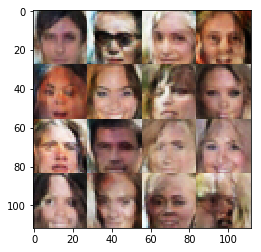

Epoch 3/10 (step: 7900)... Discriminator Loss: 0.1941... Generator Loss: 3.1368
Epoch 3/10 (step: 8000)... Discriminator Loss: 1.0189... Generator Loss: 0.7987


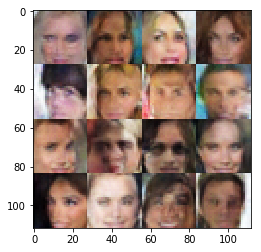

Epoch 3/10 (step: 8100)... Discriminator Loss: 3.1505... Generator Loss: 0.1176
Epoch 3/10 (step: 8200)... Discriminator Loss: 0.7777... Generator Loss: 0.9928


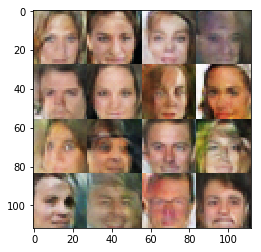

Epoch 3/10 (step: 8300)... Discriminator Loss: 0.3188... Generator Loss: 4.5737
Epoch 3/10 (step: 8400)... Discriminator Loss: 2.4278... Generator Loss: 0.1655


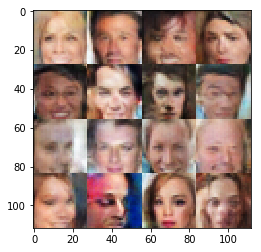

Epoch 3/10 (step: 8500)... Discriminator Loss: 0.6290... Generator Loss: 1.7242
Epoch 3/10 (step: 8600)... Discriminator Loss: 0.5377... Generator Loss: 1.5842


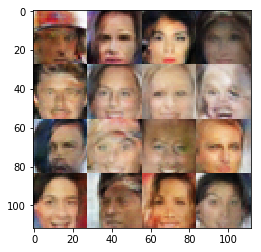

Epoch 3/10 (step: 8700)... Discriminator Loss: 0.8782... Generator Loss: 0.9786
Epoch 3/10 (step: 8800)... Discriminator Loss: 0.5696... Generator Loss: 3.1581


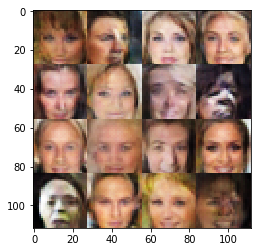

Epoch 3/10 (step: 8900)... Discriminator Loss: 1.8698... Generator Loss: 0.2255
Epoch 3/10 (step: 9000)... Discriminator Loss: 0.2860... Generator Loss: 2.9800


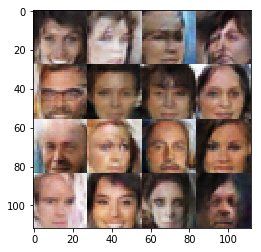

Epoch 3/10 (step: 9100)... Discriminator Loss: 0.3499... Generator Loss: 2.9870
Epoch 3/10 (step: 9200)... Discriminator Loss: 0.6759... Generator Loss: 1.0929


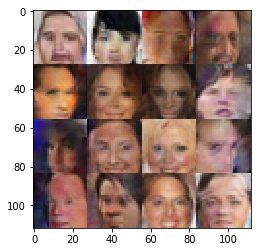

Epoch 3/10 (step: 9300)... Discriminator Loss: 0.3786... Generator Loss: 2.3392
Epoch 3/10 (step: 9400)... Discriminator Loss: 0.7596... Generator Loss: 0.9165


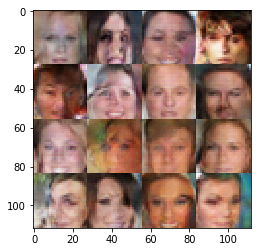

Epoch 4/10 (step: 9500)... Discriminator Loss: 0.3374... Generator Loss: 3.0429
Epoch 4/10 (step: 9600)... Discriminator Loss: 0.1129... Generator Loss: 3.2987


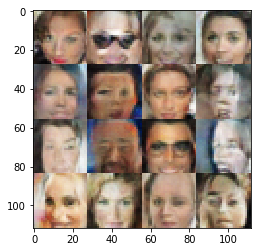

Epoch 4/10 (step: 9700)... Discriminator Loss: 0.1303... Generator Loss: 3.1829
Epoch 4/10 (step: 9800)... Discriminator Loss: 0.1386... Generator Loss: 3.3688


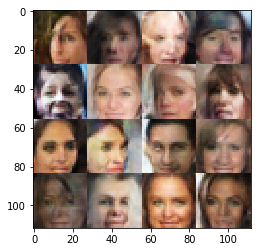

Epoch 4/10 (step: 9900)... Discriminator Loss: 0.3667... Generator Loss: 2.1471
Epoch 4/10 (step: 10000)... Discriminator Loss: 1.0752... Generator Loss: 0.7710


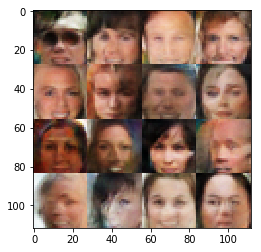

Epoch 4/10 (step: 10100)... Discriminator Loss: 0.3260... Generator Loss: 2.8763
Epoch 4/10 (step: 10200)... Discriminator Loss: 0.5160... Generator Loss: 3.8732


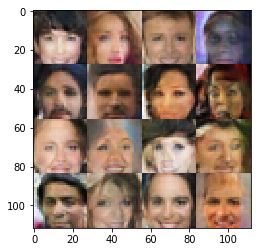

Epoch 4/10 (step: 10300)... Discriminator Loss: 1.1547... Generator Loss: 0.6981
Epoch 4/10 (step: 10400)... Discriminator Loss: 0.4858... Generator Loss: 1.5939


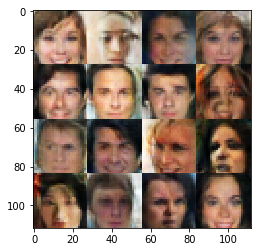

Epoch 4/10 (step: 10500)... Discriminator Loss: 0.6020... Generator Loss: 3.8941
Epoch 4/10 (step: 10600)... Discriminator Loss: 0.5369... Generator Loss: 1.2884


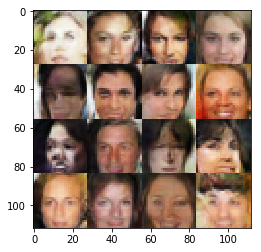

Epoch 4/10 (step: 10700)... Discriminator Loss: 0.3042... Generator Loss: 2.3153
Epoch 4/10 (step: 10800)... Discriminator Loss: 0.3830... Generator Loss: 2.1206


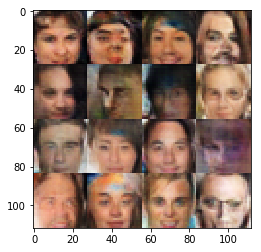

Epoch 4/10 (step: 10900)... Discriminator Loss: 0.5356... Generator Loss: 1.4440
Epoch 4/10 (step: 11000)... Discriminator Loss: 0.4800... Generator Loss: 1.9072


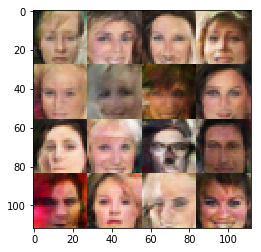

Epoch 4/10 (step: 11100)... Discriminator Loss: 0.3437... Generator Loss: 2.0094
Epoch 4/10 (step: 11200)... Discriminator Loss: 0.2113... Generator Loss: 2.6840


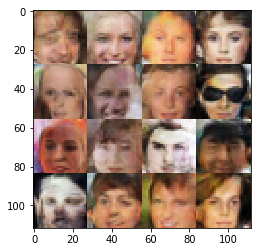

Epoch 4/10 (step: 11300)... Discriminator Loss: 0.4999... Generator Loss: 1.6363
Epoch 4/10 (step: 11400)... Discriminator Loss: 1.3256... Generator Loss: 0.6054


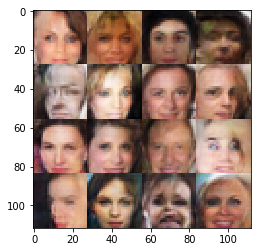

Epoch 4/10 (step: 11500)... Discriminator Loss: 1.3375... Generator Loss: 0.6925
Epoch 4/10 (step: 11600)... Discriminator Loss: 0.2575... Generator Loss: 2.8189


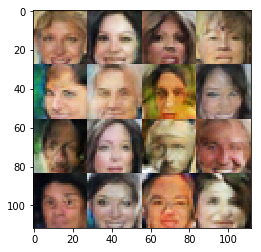

Epoch 4/10 (step: 11700)... Discriminator Loss: 0.2379... Generator Loss: 2.3127
Epoch 4/10 (step: 11800)... Discriminator Loss: 0.1869... Generator Loss: 4.6273


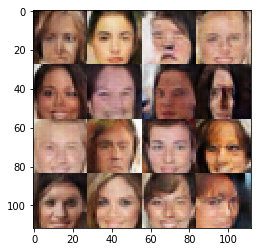

Epoch 4/10 (step: 11900)... Discriminator Loss: 0.7663... Generator Loss: 2.5291
Epoch 4/10 (step: 12000)... Discriminator Loss: 0.9176... Generator Loss: 0.9194


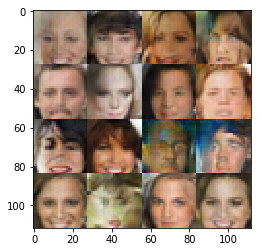

Epoch 4/10 (step: 12100)... Discriminator Loss: 0.2059... Generator Loss: 4.9735
Epoch 4/10 (step: 12200)... Discriminator Loss: 0.3643... Generator Loss: 2.5450


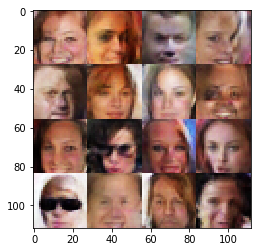

Epoch 4/10 (step: 12300)... Discriminator Loss: 0.1010... Generator Loss: 3.7460
Epoch 4/10 (step: 12400)... Discriminator Loss: 0.2540... Generator Loss: 2.8599


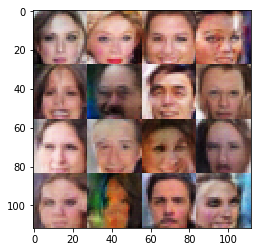

Epoch 4/10 (step: 12500)... Discriminator Loss: 0.5399... Generator Loss: 1.4309
Epoch 4/10 (step: 12600)... Discriminator Loss: 0.1824... Generator Loss: 3.3450


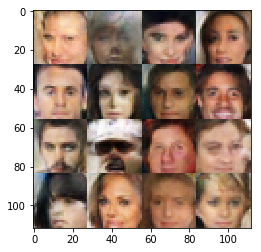

Epoch 5/10 (step: 12700)... Discriminator Loss: 0.2424... Generator Loss: 2.4658
Epoch 5/10 (step: 12800)... Discriminator Loss: 0.4066... Generator Loss: 1.5065


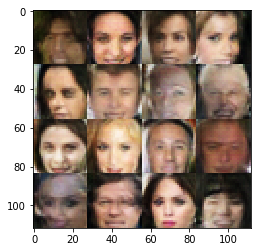

Epoch 5/10 (step: 12900)... Discriminator Loss: 1.3375... Generator Loss: 0.5240
Epoch 5/10 (step: 13000)... Discriminator Loss: 0.5699... Generator Loss: 1.4112


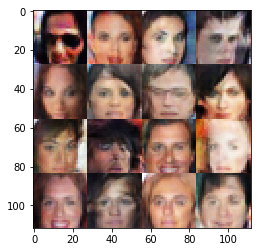

Epoch 5/10 (step: 13100)... Discriminator Loss: 0.3561... Generator Loss: 1.8382
Epoch 5/10 (step: 13200)... Discriminator Loss: 0.1129... Generator Loss: 3.2140


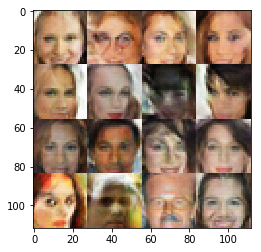

Epoch 5/10 (step: 13300)... Discriminator Loss: 0.6067... Generator Loss: 1.2092
Epoch 5/10 (step: 13400)... Discriminator Loss: 0.4311... Generator Loss: 2.7282


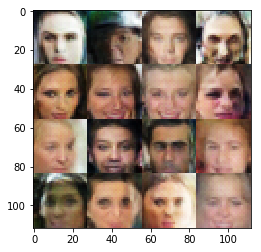

Epoch 5/10 (step: 13500)... Discriminator Loss: 0.8632... Generator Loss: 0.9381
Epoch 5/10 (step: 13600)... Discriminator Loss: 0.0851... Generator Loss: 3.3707


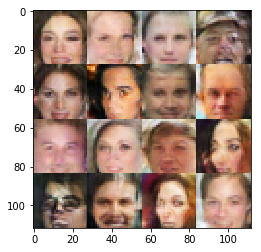

Epoch 5/10 (step: 13700)... Discriminator Loss: 0.5890... Generator Loss: 3.1612
Epoch 5/10 (step: 13800)... Discriminator Loss: 0.4554... Generator Loss: 1.5524


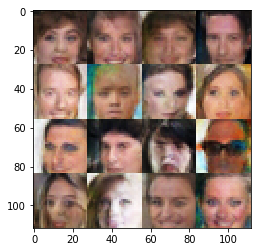

Epoch 5/10 (step: 13900)... Discriminator Loss: 0.7313... Generator Loss: 1.0031
Epoch 5/10 (step: 14000)... Discriminator Loss: 2.8881... Generator Loss: 0.1197


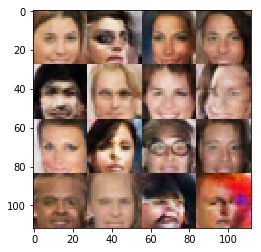

Epoch 5/10 (step: 14100)... Discriminator Loss: 0.2973... Generator Loss: 1.9901
Epoch 5/10 (step: 14200)... Discriminator Loss: 0.4890... Generator Loss: 3.2453


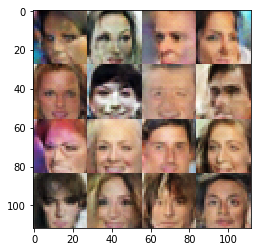

Epoch 5/10 (step: 14300)... Discriminator Loss: 0.2157... Generator Loss: 2.5175
Epoch 5/10 (step: 14400)... Discriminator Loss: 0.4046... Generator Loss: 1.8680


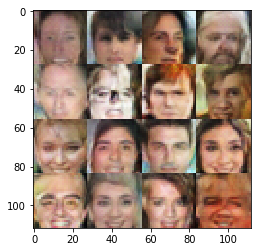

Epoch 5/10 (step: 14500)... Discriminator Loss: 0.8829... Generator Loss: 0.9270
Epoch 5/10 (step: 14600)... Discriminator Loss: 0.5069... Generator Loss: 2.1247


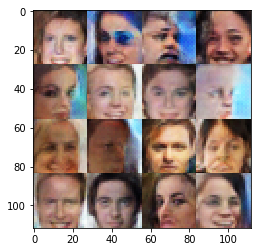

Epoch 5/10 (step: 14700)... Discriminator Loss: 0.9796... Generator Loss: 6.5303
Epoch 5/10 (step: 14800)... Discriminator Loss: 0.4042... Generator Loss: 1.8495


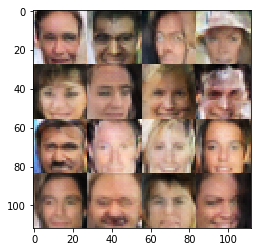

Epoch 5/10 (step: 14900)... Discriminator Loss: 0.5485... Generator Loss: 1.5253
Epoch 5/10 (step: 15000)... Discriminator Loss: 0.2151... Generator Loss: 2.6700


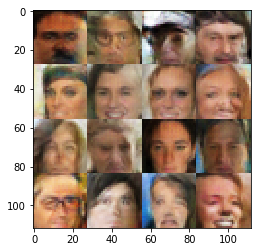

Epoch 5/10 (step: 15100)... Discriminator Loss: 1.7642... Generator Loss: 0.4421
Epoch 5/10 (step: 15200)... Discriminator Loss: 0.5325... Generator Loss: 2.7149


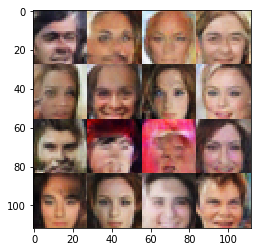

Epoch 5/10 (step: 15300)... Discriminator Loss: 0.4419... Generator Loss: 2.3665
Epoch 5/10 (step: 15400)... Discriminator Loss: 0.2119... Generator Loss: 2.5147


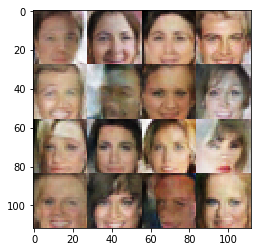

Epoch 5/10 (step: 15500)... Discriminator Loss: 0.6162... Generator Loss: 1.3907
Epoch 5/10 (step: 15600)... Discriminator Loss: 1.9517... Generator Loss: 0.2328


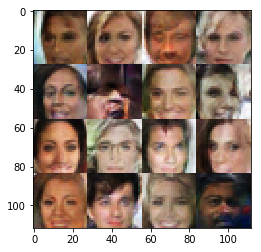

Epoch 5/10 (step: 15700)... Discriminator Loss: 0.3732... Generator Loss: 2.1200
Epoch 5/10 (step: 15800)... Discriminator Loss: 0.3763... Generator Loss: 1.9921


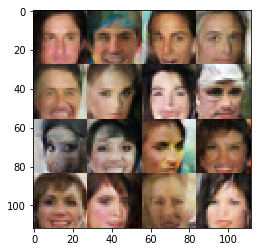

Epoch 6/10 (step: 15900)... Discriminator Loss: 0.7584... Generator Loss: 1.0263
Epoch 6/10 (step: 16000)... Discriminator Loss: 1.3215... Generator Loss: 0.7453


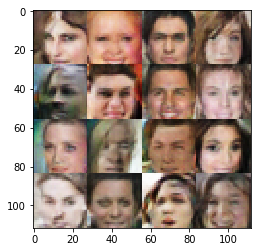

Epoch 6/10 (step: 16100)... Discriminator Loss: 0.5666... Generator Loss: 1.3230
Epoch 6/10 (step: 16200)... Discriminator Loss: 0.6105... Generator Loss: 1.6738


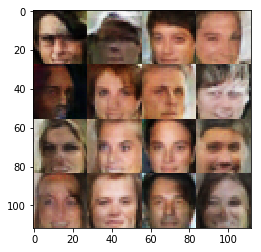

Epoch 6/10 (step: 16300)... Discriminator Loss: 0.8097... Generator Loss: 0.9701
Epoch 6/10 (step: 16400)... Discriminator Loss: 0.9479... Generator Loss: 0.9983


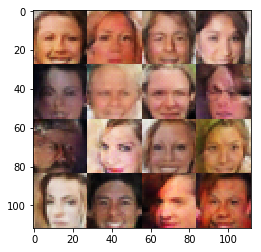

Epoch 6/10 (step: 16500)... Discriminator Loss: 0.3465... Generator Loss: 3.9646
Epoch 6/10 (step: 16600)... Discriminator Loss: 1.4298... Generator Loss: 0.7516


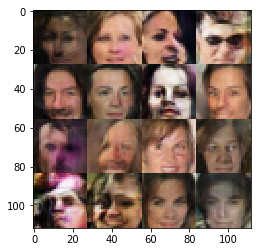

Epoch 6/10 (step: 16700)... Discriminator Loss: 0.8261... Generator Loss: 1.0954
Epoch 6/10 (step: 16800)... Discriminator Loss: 0.4828... Generator Loss: 6.3449


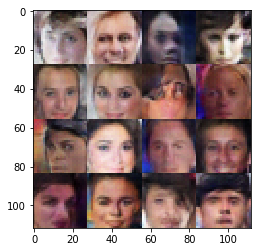

Epoch 6/10 (step: 16900)... Discriminator Loss: 0.4467... Generator Loss: 1.8256
Epoch 6/10 (step: 17000)... Discriminator Loss: 0.2786... Generator Loss: 2.5431


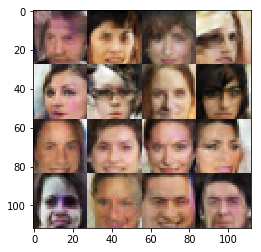

Epoch 6/10 (step: 17100)... Discriminator Loss: 0.9282... Generator Loss: 1.0496
Epoch 6/10 (step: 17200)... Discriminator Loss: 0.5824... Generator Loss: 2.0708


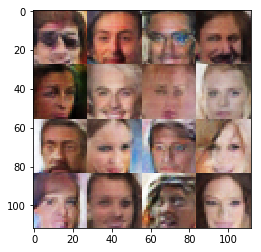

Epoch 6/10 (step: 17300)... Discriminator Loss: 1.1217... Generator Loss: 0.7601
Epoch 6/10 (step: 17400)... Discriminator Loss: 0.2212... Generator Loss: 2.5412


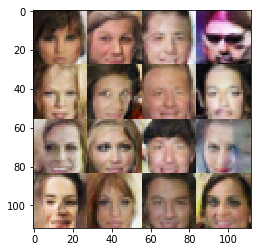

Epoch 6/10 (step: 17500)... Discriminator Loss: 2.1929... Generator Loss: 0.2307
Epoch 6/10 (step: 17600)... Discriminator Loss: 0.7033... Generator Loss: 1.2414


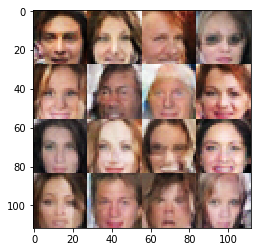

Epoch 6/10 (step: 17700)... Discriminator Loss: 0.6911... Generator Loss: 1.1838
Epoch 6/10 (step: 17800)... Discriminator Loss: 0.0416... Generator Loss: 4.8203


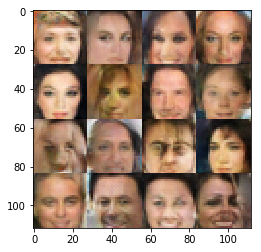

Epoch 6/10 (step: 17900)... Discriminator Loss: 0.7462... Generator Loss: 1.1486
Epoch 6/10 (step: 18000)... Discriminator Loss: 0.8569... Generator Loss: 0.9893


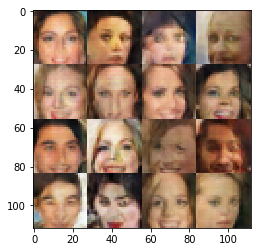

Epoch 6/10 (step: 18100)... Discriminator Loss: 0.4617... Generator Loss: 2.4506
Epoch 6/10 (step: 18200)... Discriminator Loss: 1.2805... Generator Loss: 6.4751


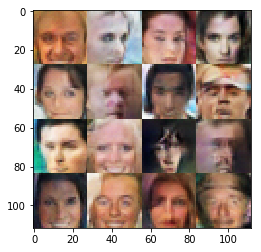

Epoch 6/10 (step: 18300)... Discriminator Loss: 0.8016... Generator Loss: 0.9323
Epoch 6/10 (step: 18400)... Discriminator Loss: 0.1510... Generator Loss: 3.2057


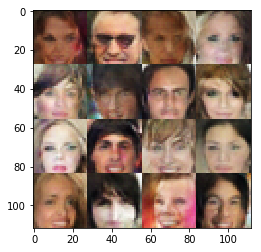

Epoch 6/10 (step: 18500)... Discriminator Loss: 0.2086... Generator Loss: 2.8155
Epoch 6/10 (step: 18600)... Discriminator Loss: 1.0364... Generator Loss: 0.8900


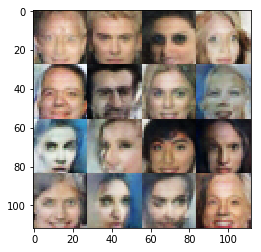

Epoch 6/10 (step: 18700)... Discriminator Loss: 0.8741... Generator Loss: 1.2463
Epoch 6/10 (step: 18800)... Discriminator Loss: 2.0974... Generator Loss: 0.3526


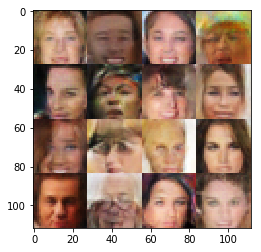

Epoch 6/10 (step: 18900)... Discriminator Loss: 0.2405... Generator Loss: 2.9883
Epoch 7/10 (step: 19000)... Discriminator Loss: 0.2593... Generator Loss: 4.9070


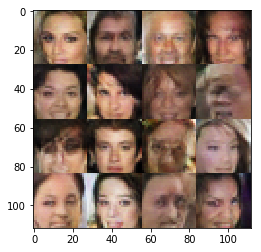

Epoch 7/10 (step: 19100)... Discriminator Loss: 0.1921... Generator Loss: 2.5851
Epoch 7/10 (step: 19200)... Discriminator Loss: 0.2331... Generator Loss: 2.9379


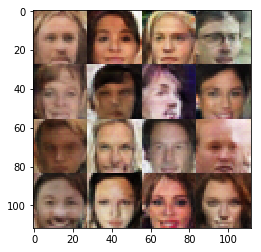

Epoch 7/10 (step: 19300)... Discriminator Loss: 0.4087... Generator Loss: 2.3209
Epoch 7/10 (step: 19400)... Discriminator Loss: 1.7181... Generator Loss: 0.4599


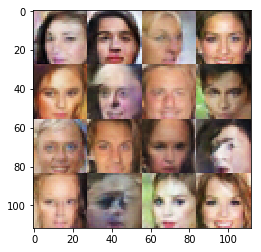

Epoch 7/10 (step: 19500)... Discriminator Loss: 0.5465... Generator Loss: 3.3470
Epoch 7/10 (step: 19600)... Discriminator Loss: 0.2025... Generator Loss: 2.8995


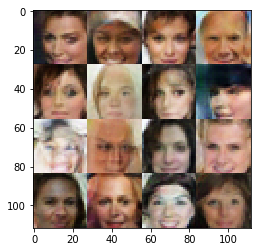

Epoch 7/10 (step: 19700)... Discriminator Loss: 0.7528... Generator Loss: 1.1496
Epoch 7/10 (step: 19800)... Discriminator Loss: 0.5389... Generator Loss: 1.3597


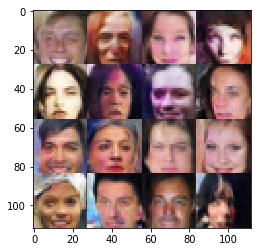

Epoch 7/10 (step: 19900)... Discriminator Loss: 0.4787... Generator Loss: 1.7333
Epoch 7/10 (step: 20000)... Discriminator Loss: 0.6683... Generator Loss: 1.4082


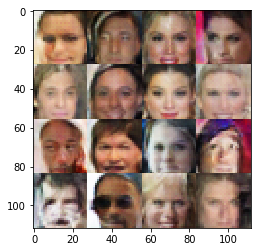

Epoch 7/10 (step: 20100)... Discriminator Loss: 0.7365... Generator Loss: 1.1258
Epoch 7/10 (step: 20200)... Discriminator Loss: 1.3424... Generator Loss: 0.5908


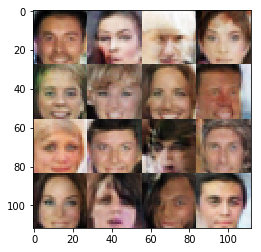

Epoch 7/10 (step: 20300)... Discriminator Loss: 0.3064... Generator Loss: 2.7565
Epoch 7/10 (step: 20400)... Discriminator Loss: 0.7938... Generator Loss: 1.0682


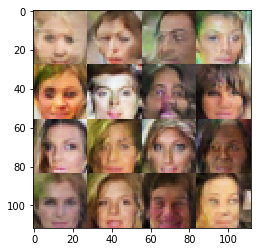

Epoch 7/10 (step: 20500)... Discriminator Loss: 1.7423... Generator Loss: 6.4535
Epoch 7/10 (step: 20600)... Discriminator Loss: 0.5360... Generator Loss: 1.5007


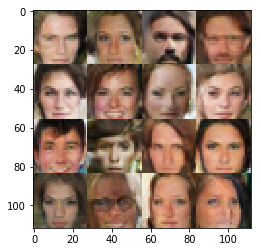

Epoch 7/10 (step: 20700)... Discriminator Loss: 2.0505... Generator Loss: 0.3724
Epoch 7/10 (step: 20800)... Discriminator Loss: 0.7863... Generator Loss: 1.1442


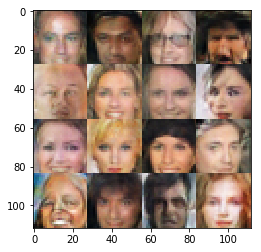

Epoch 7/10 (step: 20900)... Discriminator Loss: 0.9185... Generator Loss: 0.9993
Epoch 7/10 (step: 21000)... Discriminator Loss: 0.8358... Generator Loss: 5.1344


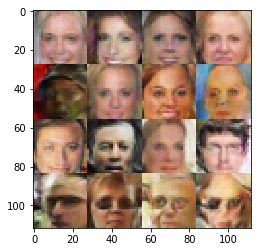

Epoch 7/10 (step: 21100)... Discriminator Loss: 0.1248... Generator Loss: 3.0437
Epoch 7/10 (step: 21200)... Discriminator Loss: 0.2345... Generator Loss: 2.3724


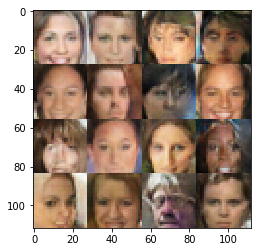

Epoch 7/10 (step: 21300)... Discriminator Loss: 0.9656... Generator Loss: 0.7901
Epoch 7/10 (step: 21400)... Discriminator Loss: 0.8109... Generator Loss: 0.9875


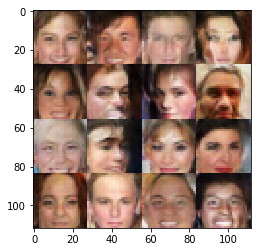

Epoch 7/10 (step: 21500)... Discriminator Loss: 0.6556... Generator Loss: 1.6554
Epoch 7/10 (step: 21600)... Discriminator Loss: 1.4720... Generator Loss: 0.5606


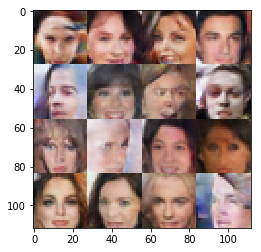

Epoch 7/10 (step: 21700)... Discriminator Loss: 1.9741... Generator Loss: 0.2607
Epoch 7/10 (step: 21800)... Discriminator Loss: 0.7444... Generator Loss: 1.1602


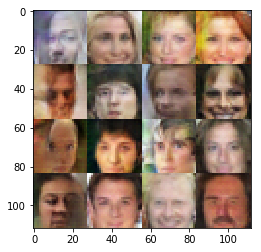

Epoch 7/10 (step: 21900)... Discriminator Loss: 1.6337... Generator Loss: 0.4997
Epoch 7/10 (step: 22000)... Discriminator Loss: 0.5180... Generator Loss: 1.6209


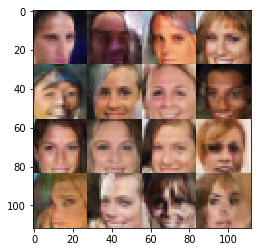

Epoch 7/10 (step: 22100)... Discriminator Loss: 0.5681... Generator Loss: 1.4787
Epoch 8/10 (step: 22200)... Discriminator Loss: 1.0754... Generator Loss: 1.0508


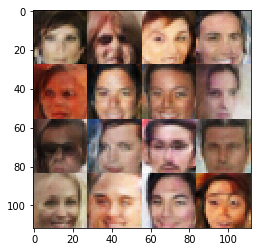

Epoch 8/10 (step: 22300)... Discriminator Loss: 0.7726... Generator Loss: 1.2537
Epoch 8/10 (step: 22400)... Discriminator Loss: 0.2032... Generator Loss: 2.6044


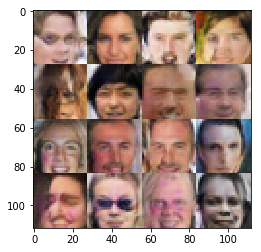

Epoch 8/10 (step: 22500)... Discriminator Loss: 0.4047... Generator Loss: 3.0343
Epoch 8/10 (step: 22600)... Discriminator Loss: 0.5341... Generator Loss: 1.4458


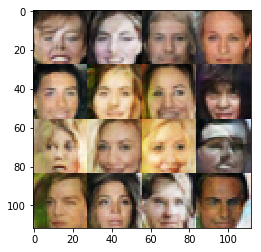

Epoch 8/10 (step: 22700)... Discriminator Loss: 0.5511... Generator Loss: 1.6071
Epoch 8/10 (step: 22800)... Discriminator Loss: 1.1878... Generator Loss: 0.7766


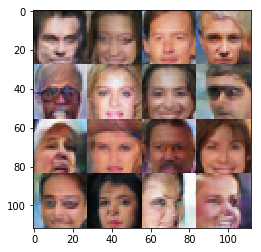

Epoch 8/10 (step: 22900)... Discriminator Loss: 0.9589... Generator Loss: 0.8964
Epoch 8/10 (step: 23000)... Discriminator Loss: 0.6645... Generator Loss: 1.1593


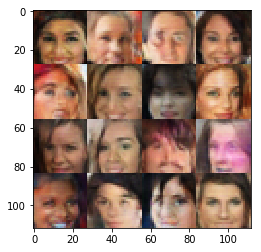

Epoch 8/10 (step: 23100)... Discriminator Loss: 1.0435... Generator Loss: 3.5511
Epoch 8/10 (step: 23200)... Discriminator Loss: 0.2470... Generator Loss: 2.7222


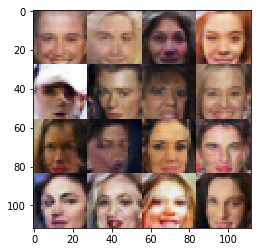

Epoch 8/10 (step: 23300)... Discriminator Loss: 0.6798... Generator Loss: 3.2447
Epoch 8/10 (step: 23400)... Discriminator Loss: 0.0899... Generator Loss: 3.6955


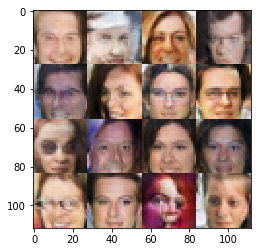

Epoch 8/10 (step: 23500)... Discriminator Loss: 0.0868... Generator Loss: 3.8472
Epoch 8/10 (step: 23600)... Discriminator Loss: 1.0985... Generator Loss: 0.9024


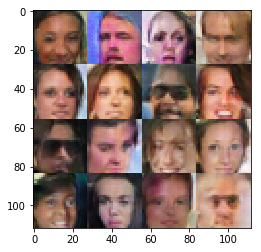

Epoch 8/10 (step: 23700)... Discriminator Loss: 0.6812... Generator Loss: 6.7398
Epoch 8/10 (step: 23800)... Discriminator Loss: 0.7851... Generator Loss: 1.2009


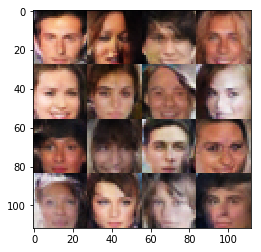

Epoch 8/10 (step: 23900)... Discriminator Loss: 0.3114... Generator Loss: 1.9651
Epoch 8/10 (step: 24000)... Discriminator Loss: 0.7008... Generator Loss: 1.3825


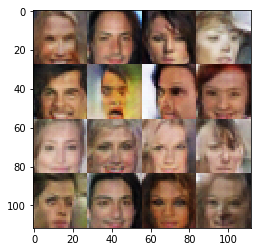

Epoch 8/10 (step: 24100)... Discriminator Loss: 0.2314... Generator Loss: 3.4484
Epoch 8/10 (step: 24200)... Discriminator Loss: 0.6253... Generator Loss: 1.3443


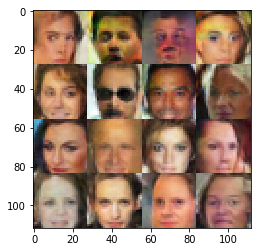

Epoch 8/10 (step: 24300)... Discriminator Loss: 0.5937... Generator Loss: 1.4604
Epoch 8/10 (step: 24400)... Discriminator Loss: 0.7410... Generator Loss: 1.4381


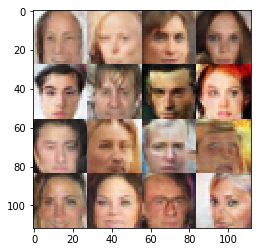

Epoch 8/10 (step: 24500)... Discriminator Loss: 0.1979... Generator Loss: 2.7287
Epoch 8/10 (step: 24600)... Discriminator Loss: 1.1662... Generator Loss: 0.8198


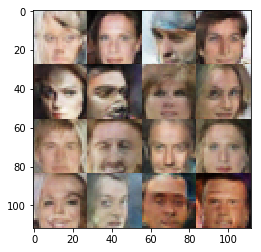

Epoch 8/10 (step: 24700)... Discriminator Loss: 0.1975... Generator Loss: 2.6655
Epoch 8/10 (step: 24800)... Discriminator Loss: 1.6140... Generator Loss: 0.7259


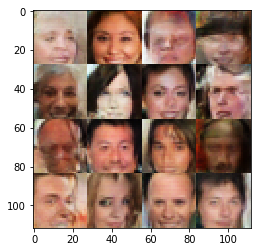

Epoch 8/10 (step: 24900)... Discriminator Loss: 0.7529... Generator Loss: 1.4045
Epoch 8/10 (step: 25000)... Discriminator Loss: 0.6506... Generator Loss: 1.2331


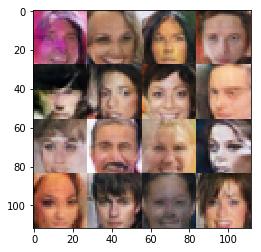

Epoch 8/10 (step: 25100)... Discriminator Loss: 0.1550... Generator Loss: 3.5168
Epoch 8/10 (step: 25200)... Discriminator Loss: 1.0333... Generator Loss: 0.9747


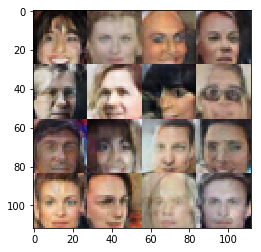

Epoch 8/10 (step: 25300)... Discriminator Loss: 0.0433... Generator Loss: 4.6981
Epoch 9/10 (step: 25400)... Discriminator Loss: 1.1672... Generator Loss: 0.7550


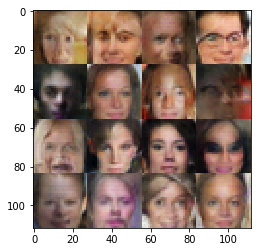

Epoch 9/10 (step: 25500)... Discriminator Loss: 0.6017... Generator Loss: 1.5164
Epoch 9/10 (step: 25600)... Discriminator Loss: 2.0255... Generator Loss: 0.3699


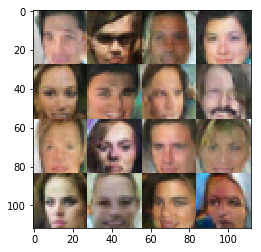

Epoch 9/10 (step: 25700)... Discriminator Loss: 0.2592... Generator Loss: 2.5853
Epoch 9/10 (step: 25800)... Discriminator Loss: 1.1360... Generator Loss: 0.8753


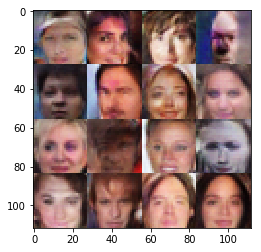

Epoch 9/10 (step: 25900)... Discriminator Loss: 3.0132... Generator Loss: 0.2412
Epoch 9/10 (step: 26000)... Discriminator Loss: 0.3174... Generator Loss: 2.0625


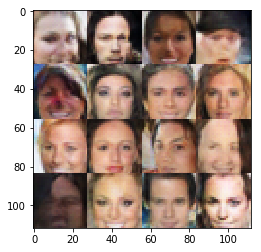

Epoch 9/10 (step: 26100)... Discriminator Loss: 0.3120... Generator Loss: 2.5589
Epoch 9/10 (step: 26200)... Discriminator Loss: 2.0789... Generator Loss: 0.3581


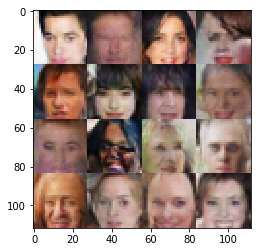

Epoch 9/10 (step: 26300)... Discriminator Loss: 0.5019... Generator Loss: 2.3003
Epoch 9/10 (step: 26400)... Discriminator Loss: 0.5551... Generator Loss: 1.4524


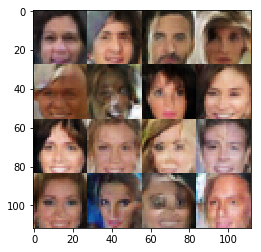

Epoch 9/10 (step: 26500)... Discriminator Loss: 1.2512... Generator Loss: 0.7143
Epoch 9/10 (step: 26600)... Discriminator Loss: 0.5826... Generator Loss: 1.4027


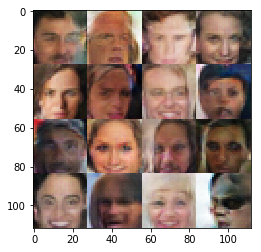

Epoch 9/10 (step: 26700)... Discriminator Loss: 0.8310... Generator Loss: 1.2679
Epoch 9/10 (step: 26800)... Discriminator Loss: 0.1890... Generator Loss: 3.1216


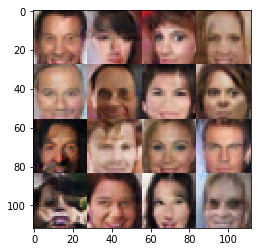

Epoch 9/10 (step: 26900)... Discriminator Loss: 0.4728... Generator Loss: 1.4716
Epoch 9/10 (step: 27000)... Discriminator Loss: 0.7113... Generator Loss: 1.2157


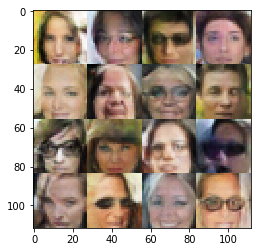

Epoch 9/10 (step: 27100)... Discriminator Loss: 1.4633... Generator Loss: 0.7255
Epoch 9/10 (step: 27200)... Discriminator Loss: 0.1386... Generator Loss: 3.5126


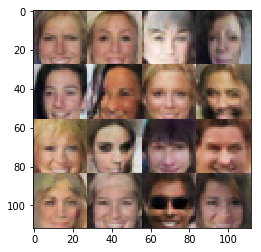

Epoch 9/10 (step: 27300)... Discriminator Loss: 0.2672... Generator Loss: 2.4686
Epoch 9/10 (step: 27400)... Discriminator Loss: 0.6645... Generator Loss: 3.9600


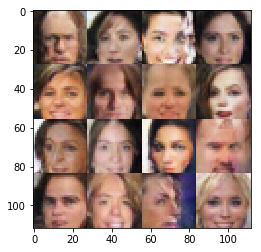

Epoch 9/10 (step: 27500)... Discriminator Loss: 0.2634... Generator Loss: 2.7768
Epoch 9/10 (step: 27600)... Discriminator Loss: 0.3051... Generator Loss: 2.4552


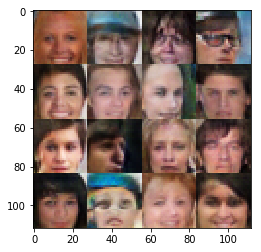

Epoch 9/10 (step: 27700)... Discriminator Loss: 1.6128... Generator Loss: 0.6807
Epoch 9/10 (step: 27800)... Discriminator Loss: 0.7629... Generator Loss: 1.3055


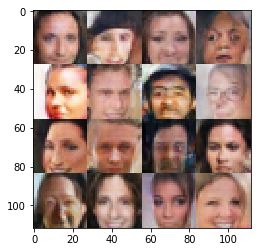

Epoch 9/10 (step: 27900)... Discriminator Loss: 0.2528... Generator Loss: 2.5011
Epoch 9/10 (step: 28000)... Discriminator Loss: 0.6475... Generator Loss: 1.4416


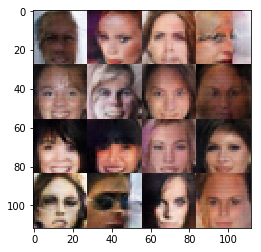

Epoch 9/10 (step: 28100)... Discriminator Loss: 0.5440... Generator Loss: 2.2097
Epoch 9/10 (step: 28200)... Discriminator Loss: 0.5820... Generator Loss: 1.4830


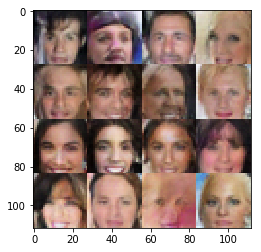

Epoch 9/10 (step: 28300)... Discriminator Loss: 0.6689... Generator Loss: 2.8282
Epoch 9/10 (step: 28400)... Discriminator Loss: 1.0535... Generator Loss: 7.3067


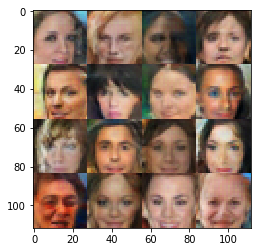

Epoch 10/10 (step: 28500)... Discriminator Loss: 0.3785... Generator Loss: 1.7976
Epoch 10/10 (step: 28600)... Discriminator Loss: 1.0492... Generator Loss: 5.6097


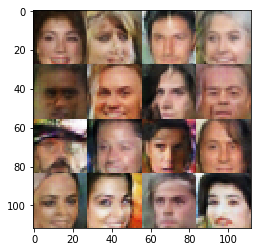

Epoch 10/10 (step: 28700)... Discriminator Loss: 1.4992... Generator Loss: 0.4574
Epoch 10/10 (step: 28800)... Discriminator Loss: 0.2131... Generator Loss: 2.7414


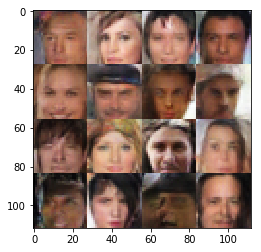

Epoch 10/10 (step: 28900)... Discriminator Loss: 0.1902... Generator Loss: 3.4858
Epoch 10/10 (step: 29000)... Discriminator Loss: 0.1345... Generator Loss: 3.5296


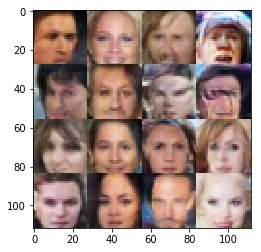

Epoch 10/10 (step: 29100)... Discriminator Loss: 2.2049... Generator Loss: 0.3546
Epoch 10/10 (step: 29200)... Discriminator Loss: 0.4102... Generator Loss: 1.9937


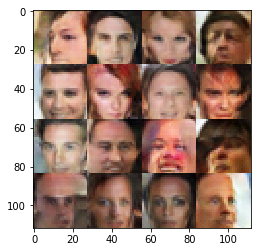

Epoch 10/10 (step: 29300)... Discriminator Loss: 0.1396... Generator Loss: 3.3513
Epoch 10/10 (step: 29400)... Discriminator Loss: 0.1766... Generator Loss: 2.7522


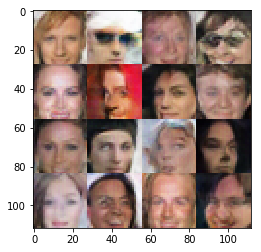

Epoch 10/10 (step: 29500)... Discriminator Loss: 0.9871... Generator Loss: 1.0492
Epoch 10/10 (step: 29600)... Discriminator Loss: 1.0720... Generator Loss: 0.7518


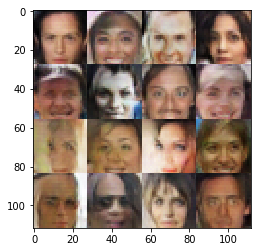

Epoch 10/10 (step: 29700)... Discriminator Loss: 0.5910... Generator Loss: 1.6495
Epoch 10/10 (step: 29800)... Discriminator Loss: 0.7514... Generator Loss: 1.2178


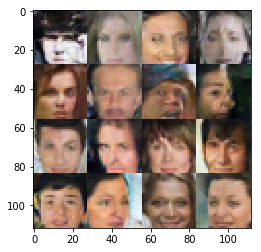

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.